In [11]:
import pandas as pd
df = pd.read_csv('Dataset/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv')
print(f"Shape: {df.shape}")
print(f"Columns:{df.columns.tolist()}")
print(f"Head:")
df.head()

Shape: (1918, 7)
Columns:['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
Head:


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [15]:
df = df.dropna(how='all')
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

df = df.drop_duplicates()

for col in df.select_dtypes(include=['object']).columns:
    sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
    if sample:
        pd.to_datetime(sample)
        df[col] = pd.to_datetime(df[col], errors='coerce')

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

df = df.reset_index(drop=True)

/tmp/ipykernel_16752/1263014052.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(sample)
/tmp/ipykernel_16752/1263014052.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [7]:
date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
df = df.sort_values(by=date_cols[0]).reset_index(drop=True)

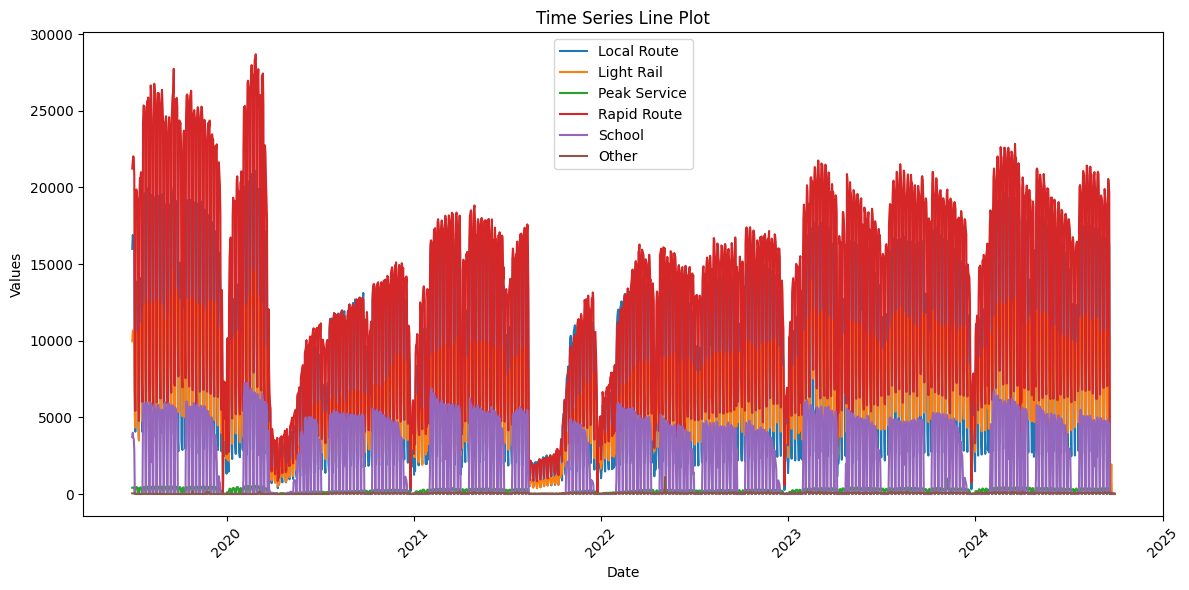

In [9]:
import matplotlib.pyplot as plt

date_col = df.select_dtypes(include=['datetime64']).columns[0]
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(12, 6))
for col in numeric_cols:
    plt.plot(df[date_col], df[col], label=col)

plt.xlabel(date_col)
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_16752/2596471579.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.set_index(date_col)[numeric_cols].resample('M').mean()


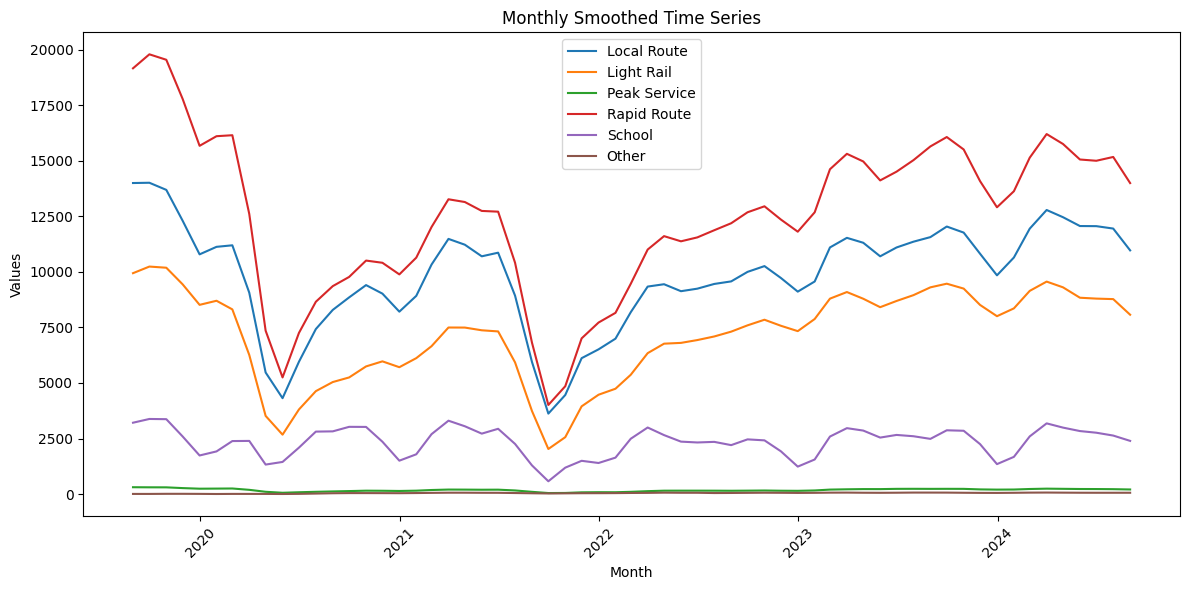

In [10]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df_monthly = df.set_index(date_col)[numeric_cols].resample('M').mean()

df_smoothed = df_monthly.rolling(window=3, center=True).mean()

plt.figure(figsize=(12, 6))
for col in numeric_cols:
    plt.plot(df_smoothed.index, df_smoothed[col], label=col)

plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Monthly Smoothed Time Series')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

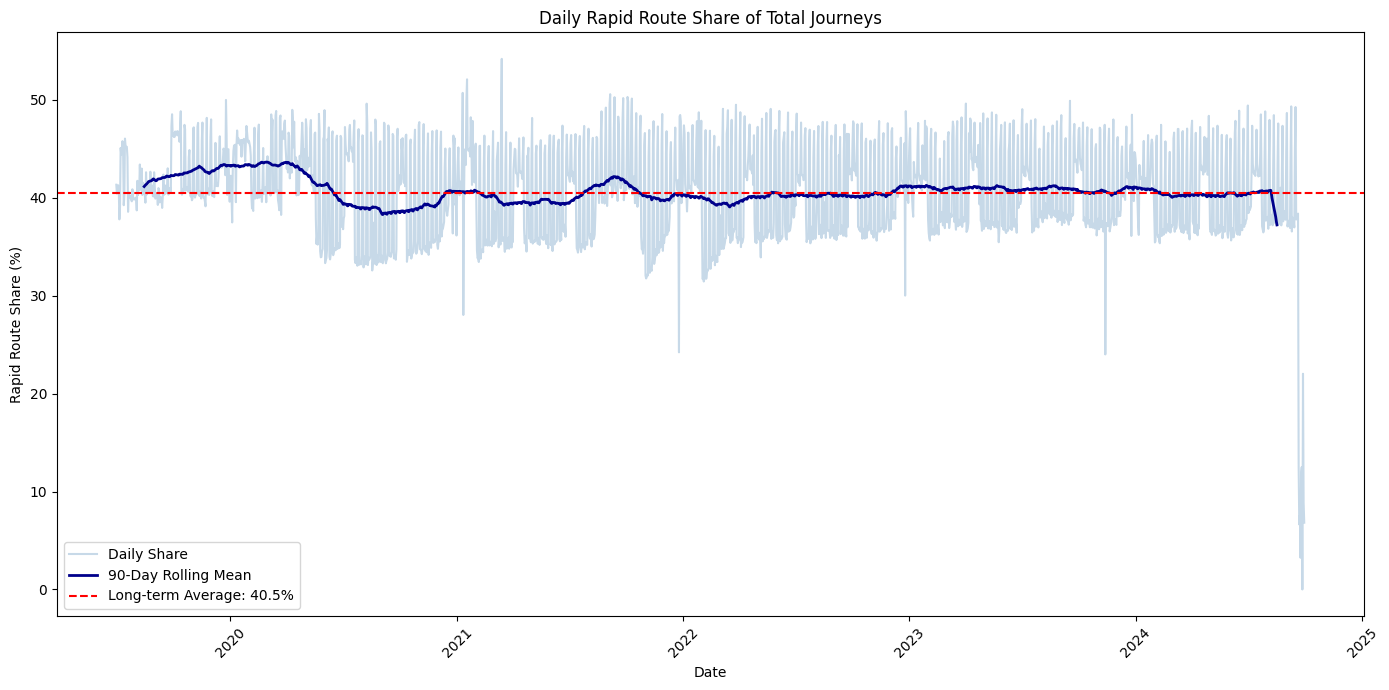

Long-term Rapid Route Share: 40.53%


In [17]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]
service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

df_sorted = df.sort_values(by=date_col).copy()
df_sorted['Total Journeys'] = df_sorted[service_cols].sum(axis=1)
df_sorted['Rapid Route Share'] = (df_sorted['Rapid Route'] / df_sorted['Total Journeys']) * 100

df_sorted['Rapid Route Share 90d MA'] = df_sorted['Rapid Route Share'].rolling(window=90, center=True).mean()

long_term_avg = df_sorted['Rapid Route Share'].mean()

plt.figure(figsize=(14, 7))
plt.plot(df_sorted[date_col], df_sorted['Rapid Route Share'], alpha=0.3, label='Daily Share', color='steelblue')
plt.plot(df_sorted[date_col], df_sorted['Rapid Route Share 90d MA'], label='90-Day Rolling Mean', color='darkblue', linewidth=2)
plt.axhline(y=long_term_avg, color='red', linestyle='--', linewidth=1.5, label=f'Long-term Average: {long_term_avg:.1f}%')

plt.xlabel('Date')
plt.ylabel('Rapid Route Share (%)')
plt.title('Daily Rapid Route Share of Total Journeys')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Long-term Rapid Route Share: {long_term_avg:.2f}%")

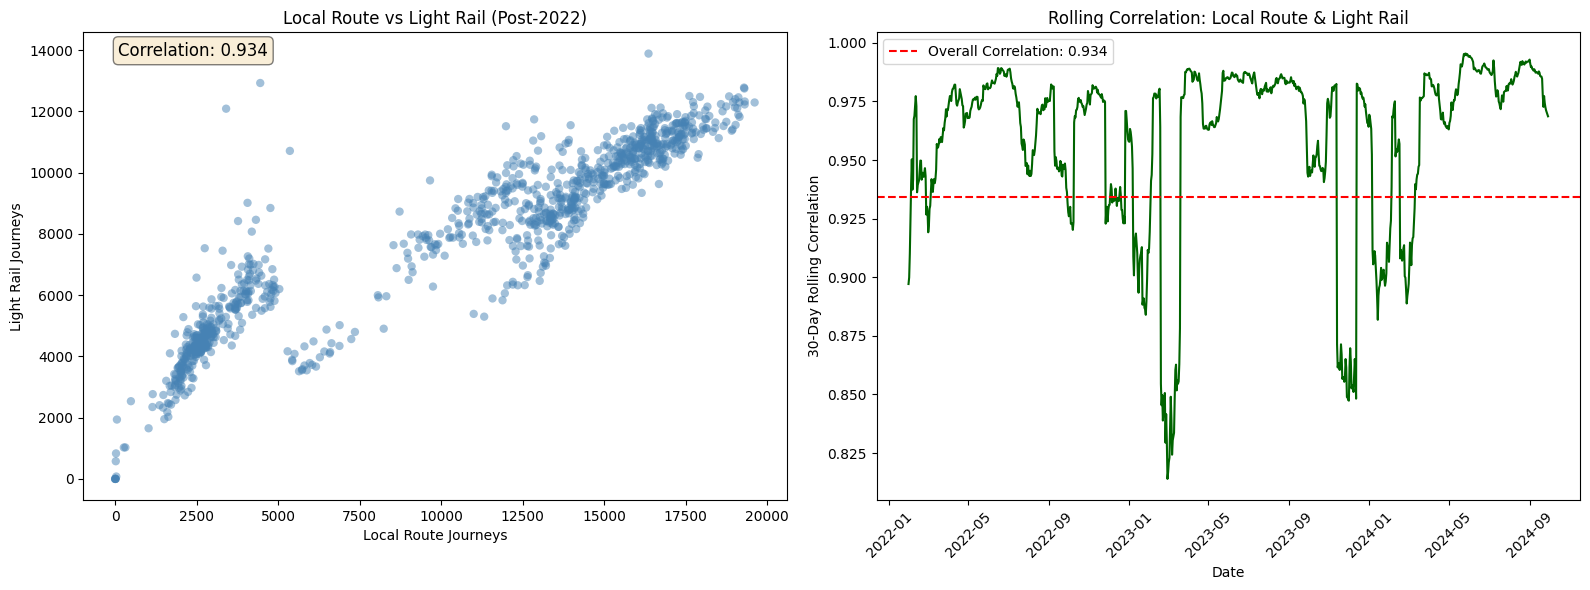

In [18]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]

df_post2022 = df[df[date_col] >= '2022-01-01'].copy()
df_post2022 = df_post2022.sort_values(by=date_col).reset_index(drop=True)

df_post2022['Rolling Correlation'] = df_post2022['Local Route'].rolling(window=30).corr(df_post2022['Light Rail'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df_post2022['Local Route'], df_post2022['Light Rail'], alpha=0.5, c='steelblue', edgecolors='none')
axes[0].set_xlabel('Local Route Journeys')
axes[0].set_ylabel('Light Rail Journeys')
axes[0].set_title('Local Route vs Light Rail (Post-2022)')

corr = df_post2022['Local Route'].corr(df_post2022['Light Rail'])
axes[0].annotate(f'Correlation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, 
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].plot(df_post2022[date_col], df_post2022['Rolling Correlation'], color='darkgreen', linewidth=1.5)
axes[1].axhline(y=corr, color='red', linestyle='--', label=f'Overall Correlation: {corr:.3f}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('30-Day Rolling Correlation')
axes[1].set_title('Rolling Correlation: Local Route & Light Rail')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

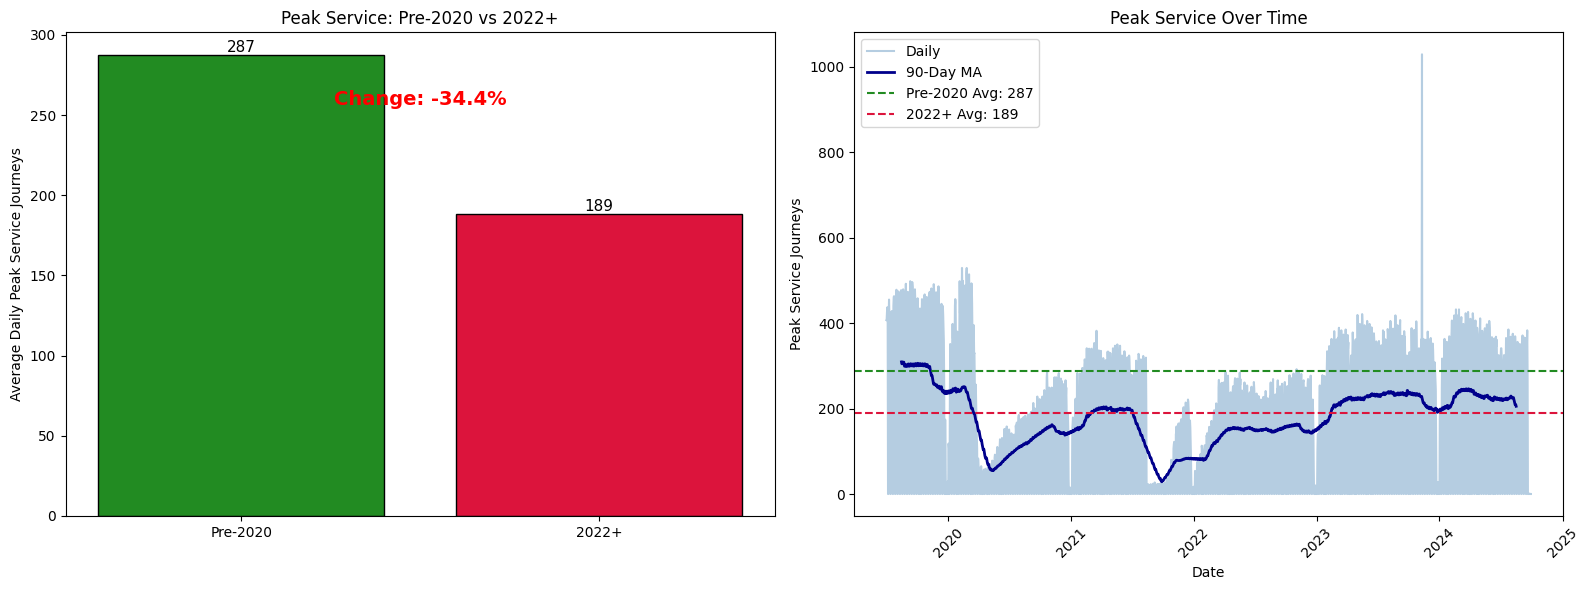

Pre-2020 Average: 287 journeys/day
2022+ Average: 189 journeys/day
Decline: -34.4%


In [19]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]
df_sorted = df.sort_values(by=date_col).copy()

df_pre2020 = df_sorted[df_sorted[date_col] < '2020-01-01']
df_post2022 = df_sorted[df_sorted[date_col] >= '2022-01-01']

avg_pre2020 = df_pre2020['Peak Service'].mean()
avg_post2022 = df_post2022['Peak Service'].mean()
pct_change = ((avg_post2022 - avg_pre2020) / avg_pre2020) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

periods = ['Pre-2020', '2022+']
averages = [avg_pre2020, avg_post2022]
colors = ['forestgreen', 'crimson']
bars = axes[0].bar(periods, averages, color=colors, edgecolor='black')
axes[0].set_ylabel('Average Daily Peak Service Journeys')
axes[0].set_title('Peak Service: Pre-2020 vs 2022+')
axes[0].bar_label(bars, fmt='%.0f', fontsize=11)
axes[0].annotate(f'Change: {pct_change:.1f}%', xy=(0.5, 0.85), xycoords='axes fraction', 
                 fontsize=14, ha='center', color='red', fontweight='bold')

axes[1].plot(df_sorted[date_col], df_sorted['Peak Service'], alpha=0.4, color='steelblue', label='Daily')
df_sorted['Peak Service 90d MA'] = df_sorted['Peak Service'].rolling(window=90, center=True).mean()
axes[1].plot(df_sorted[date_col], df_sorted['Peak Service 90d MA'], color='darkblue', linewidth=2, label='90-Day MA')
axes[1].axhline(y=avg_pre2020, color='forestgreen', linestyle='--', linewidth=1.5, label=f'Pre-2020 Avg: {avg_pre2020:.0f}')
axes[1].axhline(y=avg_post2022, color='crimson', linestyle='--', linewidth=1.5, label=f'2022+ Avg: {avg_post2022:.0f}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Peak Service Journeys')
axes[1].set_title('Peak Service Over Time')
axes[1].legend(loc='best')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Pre-2020 Average: {avg_pre2020:.0f} journeys/day")
print(f"2022+ Average: {avg_post2022:.0f} journeys/day")
print(f"Decline: {pct_change:.1f}%")

/tmp/ipykernel_16752/1814019697.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_by_year, labels=years, patch_artist=True)


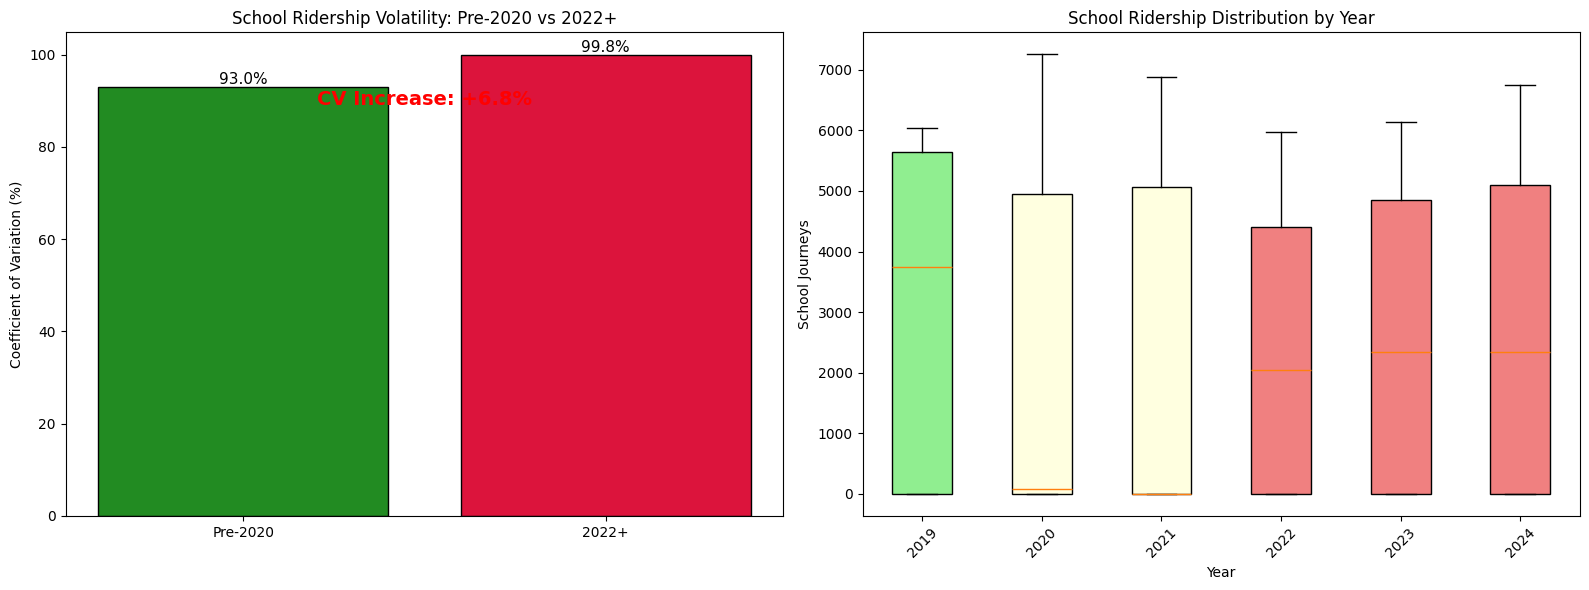

Pre-2020 CV: 93.00%
2022+ CV: 99.84%
Volatility Increase: +6.84%


In [20]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]
df_sorted = df.sort_values(by=date_col).copy()
df_sorted['Year'] = df_sorted[date_col].dt.year

df_pre2020 = df_sorted[df_sorted[date_col] < '2020-01-01']
df_post2022 = df_sorted[df_sorted[date_col] >= '2022-01-01']

cv_pre2020 = (df_pre2020['School'].std() / df_pre2020['School'].mean()) * 100
cv_post2022 = (df_post2022['School'].std() / df_post2022['School'].mean()) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

periods = ['Pre-2020', '2022+']
cv_values = [cv_pre2020, cv_post2022]
colors = ['forestgreen', 'crimson']
bars = axes[0].bar(periods, cv_values, color=colors, edgecolor='black')
axes[0].set_ylabel('Coefficient of Variation (%)')
axes[0].set_title('School Ridership Volatility: Pre-2020 vs 2022+')
axes[0].bar_label(bars, fmt='%.1f%%', fontsize=11)
cv_change = cv_post2022 - cv_pre2020
axes[0].annotate(f'CV Increase: +{cv_change:.1f}%', xy=(0.5, 0.85), xycoords='axes fraction',
                 fontsize=14, ha='center', color='red', fontweight='bold')

years = sorted(df_sorted['Year'].unique())
data_by_year = [df_sorted[df_sorted['Year'] == year]['School'].values for year in years]
bp = axes[1].boxplot(data_by_year, labels=years, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    if years[i] < 2020:
        box.set_facecolor('lightgreen')
    elif years[i] >= 2022:
        box.set_facecolor('lightcoral')
    else:
        box.set_facecolor('lightyellow')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('School Journeys')
axes[1].set_title('School Ridership Distribution by Year')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Pre-2020 CV: {cv_pre2020:.2f}%")
print(f"2022+ CV: {cv_post2022:.2f}%")
print(f"Volatility Increase: +{cv_change:.2f}%")

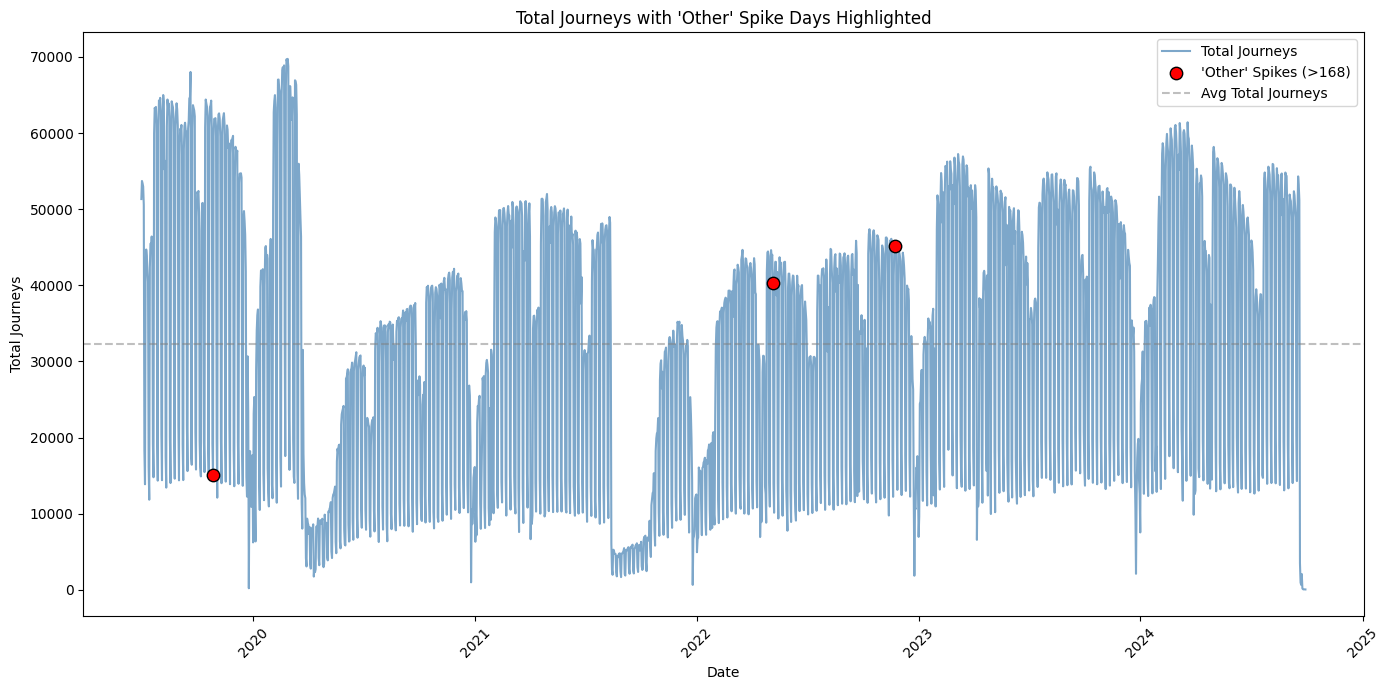

'Other' Mean: 43.36
'Other' Std: 41.53
Threshold (mean + 3*std): 167.94

Number of spike days detected: 3

Spike dates:
  2019-10-27: Other = 171, Total = 15064
  2022-05-06: Other = 1105, Total = 40349
  2022-11-23: Other = 176, Total = 45155


In [21]:
date_col = df.select_dtypes(include=['datetime64']).columns[0]
service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

df_sorted = df.sort_values(by=date_col).copy()
df_sorted['Total Journeys'] = df_sorted[service_cols].sum(axis=1)

other_mean = df_sorted['Other'].mean()
other_std = df_sorted['Other'].std()
threshold = other_mean + 3 * other_std

df_sorted['Other Spike'] = df_sorted['Other'] > threshold
spike_days = df_sorted[df_sorted['Other Spike']]

plt.figure(figsize=(14, 7))

plt.plot(df_sorted[date_col], df_sorted['Total Journeys'], color='steelblue', alpha=0.7, label='Total Journeys')

plt.scatter(spike_days[date_col], spike_days['Total Journeys'], color='red', s=80, zorder=5, 
            label=f"'Other' Spikes (>{threshold:.0f})", edgecolors='black')

plt.axhline(y=df_sorted['Total Journeys'].mean(), color='gray', linestyle='--', alpha=0.5, label='Avg Total Journeys')

plt.xlabel('Date')
plt.ylabel('Total Journeys')
plt.title("Total Journeys with 'Other' Spike Days Highlighted")
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"'Other' Mean: {other_mean:.2f}")
print(f"'Other' Std: {other_std:.2f}")
print(f"Threshold (mean + 3*std): {threshold:.2f}")
print(f"\nNumber of spike days detected: {len(spike_days)}")
if len(spike_days) > 0:
    print(f"\nSpike dates:")
    for _, row in spike_days.iterrows():
        print(f"  {row[date_col].strftime('%Y-%m-%d')}: Other = {row['Other']:.0f}, Total = {row['Total Journeys']:.0f}")

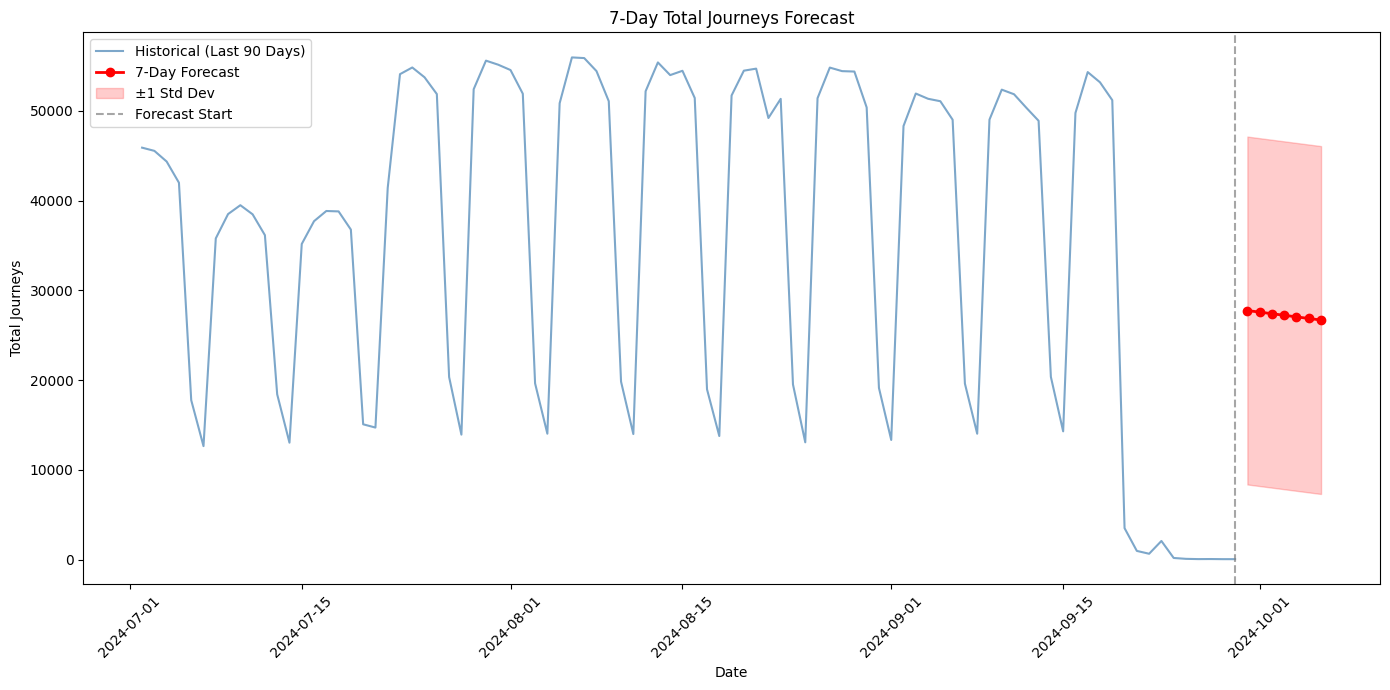

7-Day Forecast:
  2024-09-30: 27746 journeys
  2024-10-01: 27570 journeys
  2024-10-02: 27393 journeys
  2024-10-03: 27216 journeys
  2024-10-04: 27040 journeys
  2024-10-05: 26863 journeys
  2024-10-06: 26686 journeys


In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np

date_col = df.select_dtypes(include=['datetime64']).columns[0]
service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

df_sorted = df.sort_values(by=date_col).copy()
df_sorted['Total Journeys'] = df_sorted[service_cols].sum(axis=1)

df_recent = df_sorted.tail(90).copy()
df_recent['Days'] = (df_recent[date_col] - df_recent[date_col].min()).dt.days

X = df_recent['Days'].values.reshape(-1, 1)
y = df_recent['Total Journeys'].values

model = LinearRegression()
model.fit(X, y)

last_date = df_sorted[date_col].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
forecast_days = np.array([(d - df_recent[date_col].min()).days for d in forecast_dates]).reshape(-1, 1)
forecast_values = model.predict(forecast_days)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values
})

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_recent[date_col], df_recent['Total Journeys'], color='steelblue', alpha=0.7, label='Historical (Last 90 Days)')

ax.plot(forecast_df['Date'], forecast_df['Forecast'], color='red', linewidth=2, marker='o', label='7-Day Forecast')

std = df_recent['Total Journeys'].std()
ax.fill_between(forecast_df['Date'], forecast_df['Forecast'] - std, forecast_df['Forecast'] + std, 
                color='red', alpha=0.2, label='±1 Std Dev')

ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')

ax.set_xlabel('Date')
ax.set_ylabel('Total Journeys')
ax.set_title('7-Day Total Journeys Forecast')
ax.legend(loc='best')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("7-Day Forecast:")
for _, row in forecast_df.iterrows():
    print(f"  {row['Date'].strftime('%Y-%m-%d')}: {row['Forecast']:.0f} journeys")